## **Importing Libraries**

In [17]:
import pandas as pd
import requests
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

## **Fetching image from url**

In [3]:
# Helper function to fetch dominant color
def get_dominant_color(image_url):
    response = requests.get(image_url)
    image = Image.open(io.BytesIO(response.content)).resize((100, 100)).convert('RGB')
    pixels = np.array(image).reshape(-1, 3)
    kmeans = KMeans(n_clusters=1)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_[0].astype(int)

## **Loading Dataset**

In [4]:

# Load the dataset
dataset_path = 'pinterest-fashion-dataset.csv'
df = pd.read_csv(dataset_path)

In [5]:
# Data Cleaning: Drop rows with missing or invalid values
df.dropna(subset=['price', 'click_rate', 'age', 'gender', 'category', 'brand', 'ratings', 'image_url'], inplace=True)

## **Price Distribution Graph**

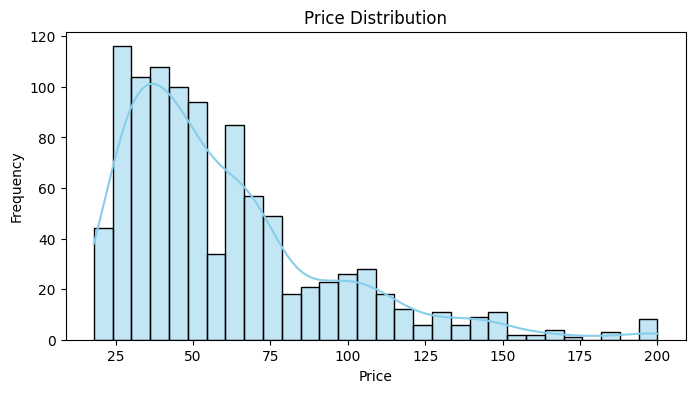

In [6]:
# EDA: Visualize price distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['price'], bins=30, kde=True, color='skyblue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

## **Correlation Heatmap**

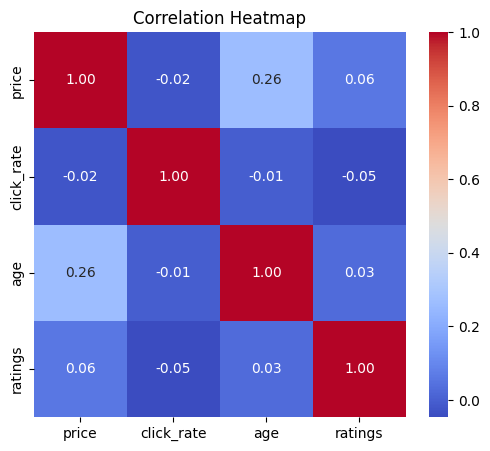

In [7]:
# EDA: Correlation heatmap
numerical_features = ['price', 'click_rate', 'age', 'ratings']
plt.figure(figsize=(6, 5))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## **Color Distribution**

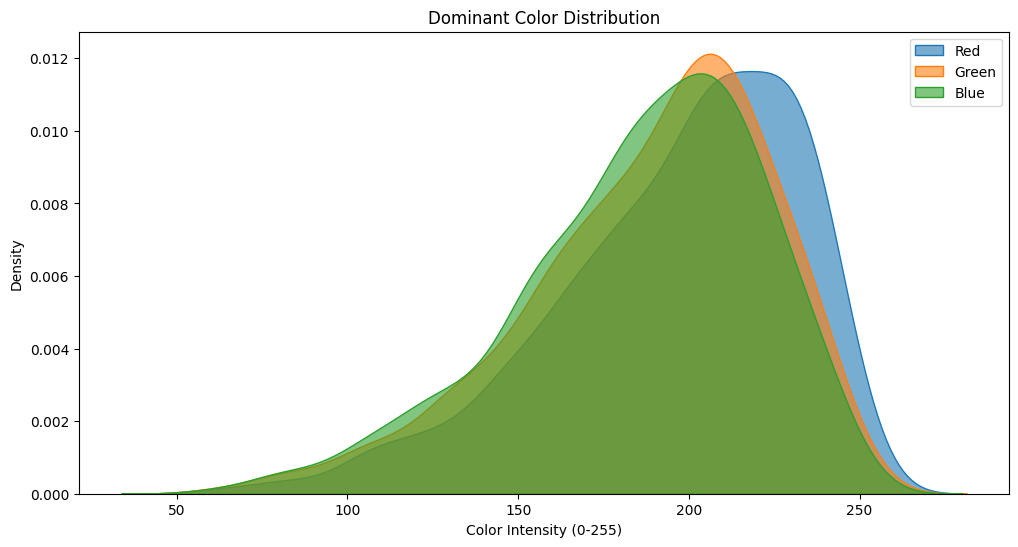

In [8]:
dominant_colors = []
for url in df['image_url']:
    dominant_colors.append(get_dominant_color(url))

# Convert dominant colors to a DataFrame
dominant_colors_df = pd.DataFrame(dominant_colors, columns=['R', 'G', 'B'])

# Add dominant colors back to the dataset (optional, for future use)
df['dominant_R'] = dominant_colors_df['R']
df['dominant_G'] = dominant_colors_df['G']
df['dominant_B'] = dominant_colors_df['B']

# Visualize the color distribution
plt.figure(figsize=(12, 6))

# Plot R, G, B distributions
for color, label in zip(['R', 'G', 'B'], ['Red', 'Green', 'Blue']):
    sns.kdeplot(dominant_colors_df[color], label=label, fill=True, alpha=0.6)

plt.title("Dominant Color Distribution")
plt.xlabel("Color Intensity (0-255)")
plt.ylabel("Density")
plt.legend()
plt.show()


## **Clustered Image**

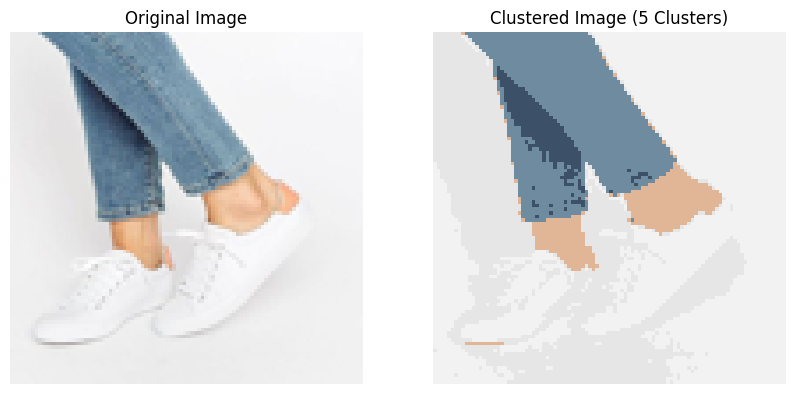

In [9]:
# Helper function to display clustered image
def display_clustered_image(image_url, n_clusters=5):
    # Fetch the image
    response = requests.get(image_url)
    image = Image.open(io.BytesIO(response.content)).resize((100, 100)).convert('RGB')
    pixels = np.array(image).reshape(-1, 3)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    # Reconstruct the image using the cluster centers
    clustered_pixels = cluster_centers[labels].astype(int).reshape(100, 100, 3)

    # Display original and clustered image
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(clustered_pixels / 255)
    axes[1].set_title(f"Clustered Image ({n_clusters} Clusters)")
    axes[1].axis('off')

    plt.show()

# Example: Display clusters for the first image in the dataset
sample_image_url = df['image_url'].iloc[0]
display_clustered_image(sample_image_url, n_clusters=5)


## **Feature Engineering**

In [10]:
# Feature Engineering
X = []
y = []
for _, entry in df.iterrows():
    price = entry['price']
    click_rate = entry['click_rate']
    age = entry['age']
    gender = 1 if entry['gender'] == 'Male' else 0
    category = entry['category']
    brand = entry['brand']
    ratings = entry['ratings']
    dominant_color = get_dominant_color(entry['image_url'])

    X.append([price, click_rate, age, gender, category, brand, ratings])
    y.append(dominant_color)

X_df = pd.DataFrame(X, columns=['price', 'click_rate', 'age', 'gender', 'category', 'brand', 'ratings'])
y = np.array(y)

## **Preprocessing**

In [11]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['price', 'click_rate', 'age', 'gender', 'ratings']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['category', 'brand'])
    ])


## **Model Selection**

In [12]:

# Model Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])


## **Dataset Splitting**

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3, random_state=42)


## **Model Comparisons**

Random Forest - Mean Squared Error: 1214.61
Linear Regression - Mean Squared Error: 1301.04
Support Vector Regressor (SVR) - Mean Squared Error: 1292.72
K-Nearest Neighbors - Mean Squared Error: 1229.10


<ipython-input-18-5c14c8197e1a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


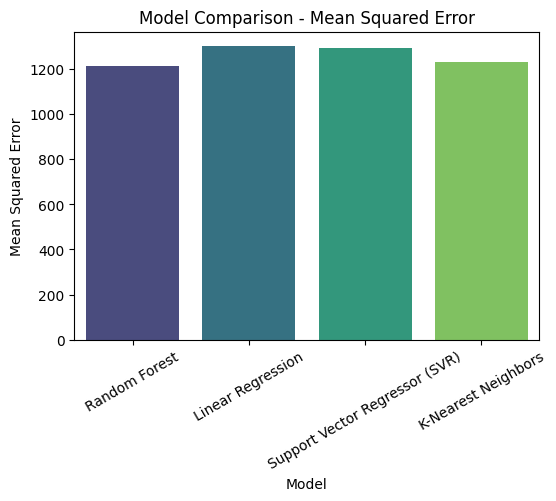

In [18]:
from sklearn.multioutput import MultiOutputRegressor

# Define models for comparison with MultiOutputRegressor
models = {
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "Support Vector Regressor (SVR)": MultiOutputRegressor(SVR()),
    "K-Nearest Neighbors": MultiOutputRegressor(KNeighborsRegressor())
}

# Results dictionary to store performance
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[model_name] = mse
    print(f"{model_name} - Mean Squared Error: {mse:.2f}")

# Visualize model comparison
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.title("Model Comparison - Mean Squared Error")
plt.ylabel("Mean Squared Error")
plt.xlabel("Model")
plt.xticks(rotation=30)
plt.show()


## **Hyperparameter Tuning**

In [19]:
# Hyperparameter Tuning
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20]
}
grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['price',
                                                                          'click_rate',
                                                                          'age',
                                                                          'gender',
                                                                          'ratings']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['category',
                                                                          'brand'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

## **Best Model**

In [20]:
# Best model and evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")



Mean Squared Error: 1155.0626264496943


## **Visualizing RGB Predictions**

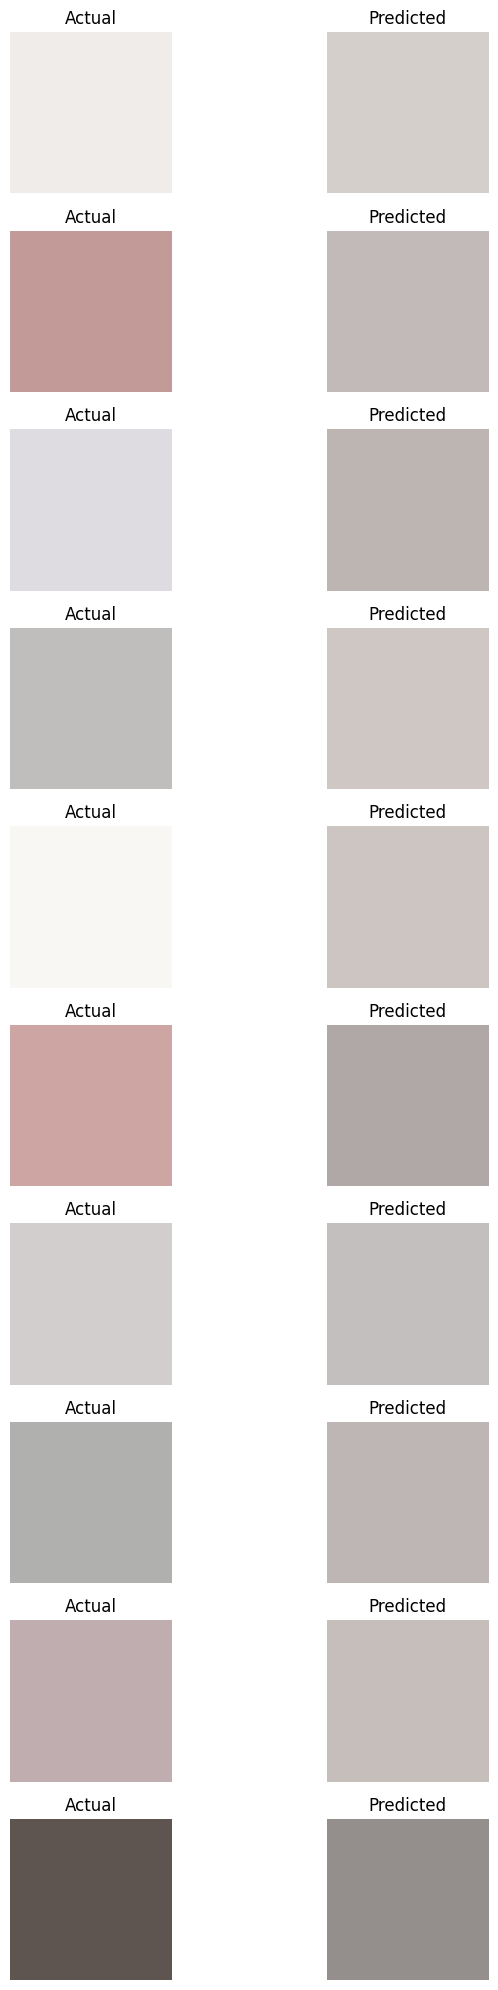

In [21]:
# Visualizing RGB predictions
actual_colors = y_test.reshape(-1, 3)
predicted_colors = y_pred.reshape(-1, 3)

fig, ax = plt.subplots(10, 2, figsize=(8, 20))
for i in range(10):
    ax[i, 0].imshow([[actual_colors[i] / 255]])
    ax[i, 0].set_title("Actual")
    ax[i, 0].axis('off')

    ax[i, 1].imshow([[predicted_colors[i] / 255]])
    ax[i, 1].set_title("Predicted")
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

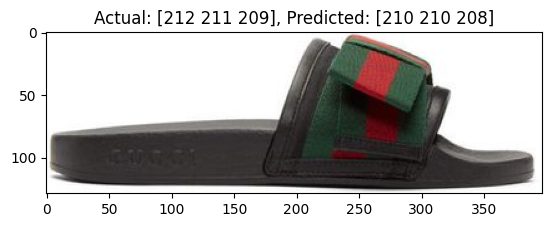

In [22]:
# Set the index of the sample image you want to visualize
sample_index = 37

# Get the image URL from the DataFrame using the specified sample index
sample_image_url = df.iloc[sample_index]["image_url"]

# Get the actual dominant color for the sample from the test set
actual_color = y_test[sample_index]

# Get the predicted dominant color for the sample from the model's predictions
predicted_color = y_pred[sample_index]

# Send a GET request to fetch the image from the sample's image URL
response = requests.get(sample_image_url)

# Open the image using PIL (Python Imaging Library) from the response content
image = Image.open(io.BytesIO(response.content))

# Display the image
plt.imshow(image)

# Set the title of the image showing both actual and predicted dominant colors
# The predicted color is cast to integers for display purposes
plt.title(f"Actual: {actual_color}, Predicted: {predicted_color.astype(int)}")

# Show the image with the title
plt.show()
